# Day 4: Histogram of Oriented Gradients (HOG)

Understanding feature extraction before the deep learning era.

## 1. Setup and Imports

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


## 2. What is HOG?

Histogram of Oriented Gradients (HoG) is a global feature representation, in the sense that one feature description is calculated for the entire image or an image-patch. The descriptor is a vector which contains many histograms. Each histogram belongs to a local area within the image and counts the frequency of gradient-directions in this local area.

HOG is a feature descriptor used for object detection and tracking, introduced by [Dalal and Triggs (2005); Histograms of Oriented Gradients for Human Detection](http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf).

**Why important before CNNs:**
- Robust to geometric and photometric transformations
- Captures edge and gradient structure efficiently
- State-of-the-art for pedestrian detection (2005-2012)
- Computationally efficient compared to raw pixels
- Foundation for understanding local feature descriptors

## 3. Image Gradients

### 3.1 Theory

Gradient magnitude:

$$G = \sqrt{G_x^2 + G_y^2}$$

Gradient orientation:

$$\theta = \arctan\left(\frac{G_y}{G_x}\right)$$

Where:
- $G_x = I * [-1, 0, 1]$ (horizontal gradient)
- $G_y = I * [-1, 0, 1]^T$ (vertical gradient)

In [19]:
img = cv2.imread('images/pedestrian.jpg',cv2.IMREAD_COLOR_RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

print(f"Image shape: {gray.shape}")

Image shape: (361, 950)


In [20]:
# Compute gradients
gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=1)
gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=1)

magnitude = np.sqrt(gx**2 + gy**2)
orientation = np.arctan2(gy, gx) * (180 / np.pi) % 180

print(f"Gradient magnitude range: [{magnitude.min():.2f}, {magnitude.max():.2f}]")
print(f"Gradient orientation range: [{orientation.min():.2f}, {orientation.max():.2f}] degrees")

Gradient magnitude range: [0.00, 298.61]
Gradient orientation range: [0.00, 179.72] degrees


### 3.2 Visualization

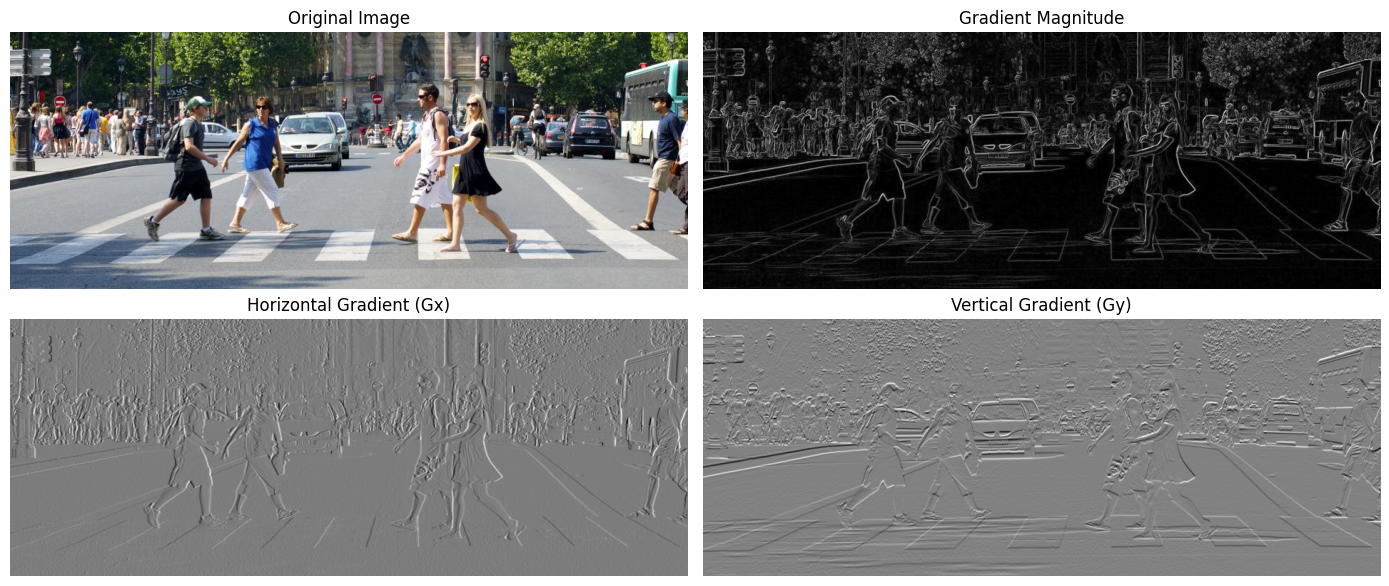

In [21]:
plt.figure(figsize=(14, 6))

plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(magnitude, cmap='gray')
plt.title('Gradient Magnitude')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(gx, cmap='gray')
plt.title('Horizontal Gradient (Gx)')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(gy, cmap='gray')
plt.title('Vertical Gradient (Gy)')
plt.axis('off')

plt.tight_layout()
plt.show()

## 4. HOG Descriptor Formation

### 4.1 Pipeline

1. **Cell Division**: Image divided into small cells (e.g., 8×8 pixels)
2. **Gradient Computation**: Calculate magnitude and orientation for each pixel
3. **Histogram Creation**: For each cell, create histogram of gradient orientations (e.g., 9 bins for 0-180°)
4. **Block Normalization**: Normalize histograms over larger blocks (e.g., 2×2 cells)
5. **Descriptor Vector**: Concatenate all normalized histograms

### 4.2 Mathematical Formulation

For each block, L2-norm normalization:

$$v_{\text{normalized}} = \frac{v}{\sqrt{\|v\|_{2}^{2} + \epsilon^2}}$$

Where $v$ is the histogram vector and $\epsilon$ is a small constant.

In [22]:
# HOG parameters
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)

# Compute HOG features
features, hog_image = hog(
    gray,
    orientations=orientations,
    pixels_per_cell=pixels_per_cell,
    cells_per_block=cells_per_block,
    visualize=True,
    feature_vector=True
)

print(f"HOG feature vector length: {len(features)}")
print(f"Feature statistics - Mean: {features.mean():.4f}, Std: {features.std():.4f}")

HOG feature vector length: 185328
Feature statistics - Mean: 0.1307, Std: 0.1034


### 4.3 HOG Visualization

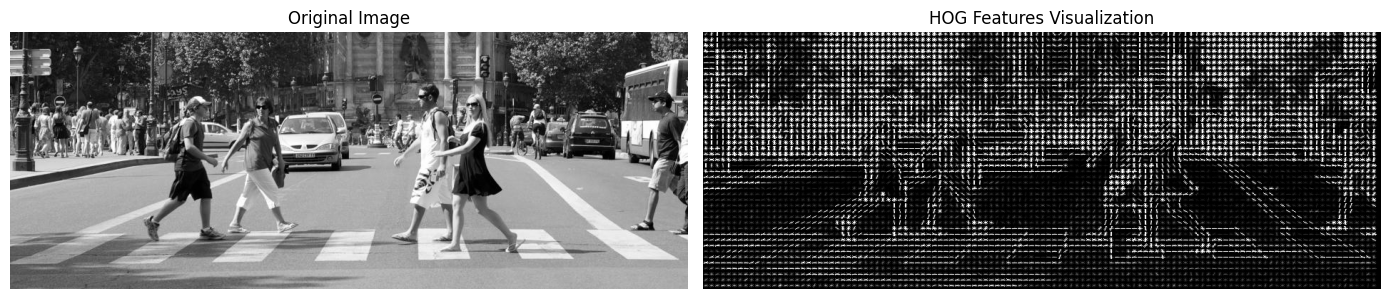

In [23]:
# Rescale HOG image for better visualization
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(gray, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(hog_image_rescaled, cmap='gray')
plt.title('HOG Features Visualization')
plt.axis('off')

plt.tight_layout()
plt.show()

## 5. Manual HOG Computation

In [24]:
def compute_hog(image, cell_size=8, bin_count=9):
    """
    Simplified HOG computation for educational purposes.
    """
    gx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=1)
    gy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=1)
    
    magnitude = np.sqrt(gx**2 + gy**2)
    orientation = np.arctan2(gy, gx) * (180 / np.pi) % 180
    
    height, width = image.shape
    cells_y = height // cell_size
    cells_x = width // cell_size
    
    histograms = []
    
    for i in range(cells_y):
        for j in range(cells_x):
            y_start = i * cell_size
            y_end = (i + 1) * cell_size
            x_start = j * cell_size
            x_end = (j + 1) * cell_size
            
            cell_mag = magnitude[y_start:y_end, x_start:x_end]
            cell_ori = orientation[y_start:y_end, x_start:x_end]
            
            hist, _ = np.histogram(
                cell_ori,
                bins=bin_count,
                range=(0, 180),
                weights=cell_mag
            )
            
            histograms.append(hist)
    
    return np.array(histograms)
gray_resize = cv2.resize(gray, (64,128))
hog_features_manual = compute_hog(gray_resize)
print(f"HOG shape: {hog_features_manual.shape}")
print(f"Total cells: {hog_features_manual.shape[0]}")
print(f"Bins per cell: {hog_features_manual.shape[1]}")

HOG shape: (128, 9)
Total cells: 128
Bins per cell: 9


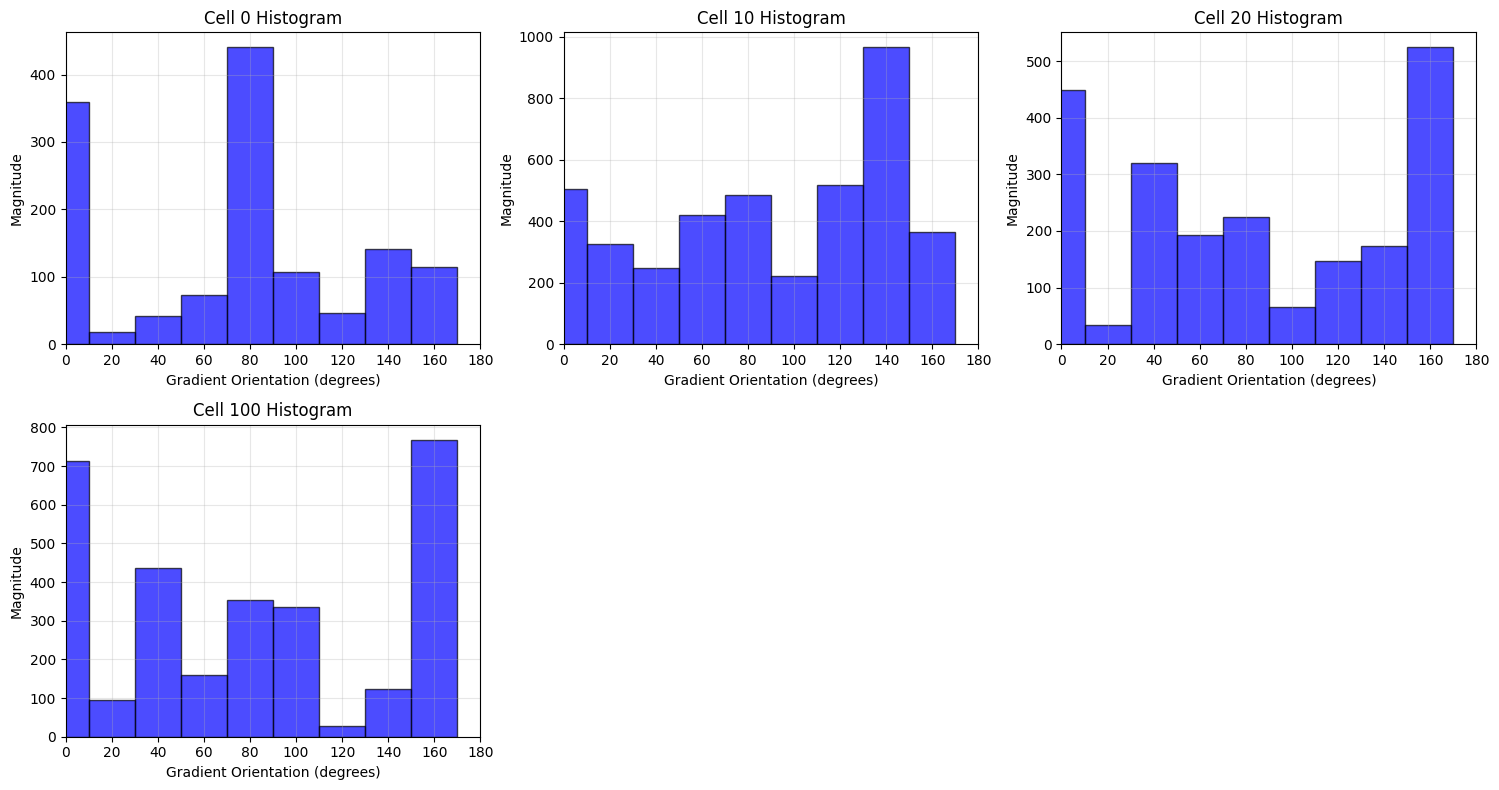

In [25]:
# Visualize HOG histograms for sample cells
plt.figure(figsize=(15, 8))

# Select a few cells to visualize
sample_cells = [0, 10, 20, 100, 200, 300]
bin_count = hog_features_manual.shape[1]  

for idx, cell_idx in enumerate(sample_cells):
    if cell_idx < len(hog_features_manual):
        plt.subplot(2, 3, idx + 1)
        
        # Plot histogram
        bins = np.arange(0, 180, 180 / bin_count)
        plt.bar(bins, hog_features_manual[cell_idx], width=180/bin_count, alpha=0.7, color='blue', edgecolor='black')
        plt.xlabel('Gradient Orientation (degrees)')
        plt.ylabel('Magnitude')
        plt.title(f'Cell {cell_idx} Histogram')
        plt.xlim(0, 180)
        plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

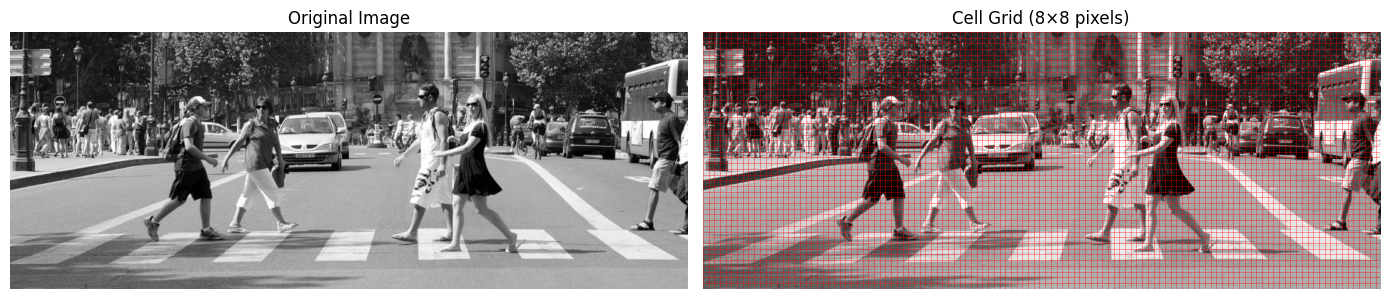

Image divided into 128 cells
Each cell has 9 orientation bins


In [26]:
# Visualize cell grid on image
plt.figure(figsize=(14, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(gray, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Image with cell grid overlay
plt.subplot(1, 2, 2)
plt.imshow(gray, cmap='gray')

# Draw grid lines
cell_size = 8
height, width = gray.shape
for i in range(0, height, cell_size):
    plt.axhline(i, color='red', linewidth=0.5, alpha=0.5)
for j in range(0, width, cell_size):
    plt.axvline(j, color='red', linewidth=0.5, alpha=0.5)

plt.title(f'Cell Grid ({cell_size}×{cell_size} pixels)')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Image divided into {hog_features_manual.shape[0]} cells")
print(f"Each cell has {hog_features_manual.shape[1]} orientation bins")

## 6. HOG + SVM for Pedestrian Detection

### 6.1 Load Dataset

Place pedestrian images in:
- `images/pedestrians/` (positive samples)
- `images/non_pedestrians/` (negative samples)

In [27]:
from glob import glob

def load_and_extract_features(image_paths, target_size=(64, 128)):
    """
    Load images and extract HOG features.
    """
    features = []
    
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        
        img_resized = cv2.resize(img, target_size)
        
        hog_features = hog(
            img_resized,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=False,
            feature_vector=True
        )
        
        features.append(hog_features)
    
    return np.array(features)

# Load dataset
pos_paths = glob('images/pedestrians/*.png')
neg_paths = glob('images/non_pedestrians/*.png')

print(f"Found {len(pos_paths)} pedestrian images")
print(f"Found {len(neg_paths)} non-pedestrian images")

# Extract HOG features
print("Extracting HOG features..")
X_pos = load_and_extract_features(pos_paths)
X_neg = load_and_extract_features(neg_paths)

# Combine datasets
X = np.vstack([X_pos, X_neg])
y = np.hstack([np.ones(len(X_pos)), np.zeros(len(X_neg))])

print(f"\nDataset: {X.shape[0]} samples, {X.shape[1]} features per sample")
print(f"Positive samples: {len(X_pos)}")
print(f"Negative samples: {len(X_neg)}")

Found 614 pedestrian images
Found 600 non-pedestrian images
Extracting HOG features..

Dataset: 1214 samples, 3780 features per sample
Positive samples: 614
Negative samples: 600


### 6.2 Train SVM Classifier

In [28]:
# Train SVM Classifier
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Train SVM with linear kernel
print("\nTraining SVM classifier...")
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

svm_classifier.fit(X_train, y_train)

Training set: 971 samples
Test set: 243 samples

Training SVM classifier...


SVC(random_state=42)

In [29]:
# Evaluate
y_pred = svm_classifier.predict(X_test)

print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Pedestrian', 'Pedestrian']))


Accuracy: 0.8848

Classification Report:
                precision    recall  f1-score   support

Non-Pedestrian       0.88      0.89      0.88       120
    Pedestrian       0.89      0.88      0.89       123

      accuracy                           0.88       243
     macro avg       0.88      0.88      0.88       243
  weighted avg       0.88      0.88      0.88       243



### Test on Individual Images

In [30]:
def predict_image(image_path, classifier, target_size=(64, 128)):
    """
    Predict whether an image contains a pedestrian or not.
    """
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image from {image_path}")
        return None
    
    # Convert to grayscale and resize
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(gray, target_size)
    
    # Extract HOG features
    hog_features = hog(
        img_resized,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=False,
        feature_vector=True
    )
    
    # Predict
    prediction = classifier.predict([hog_features])[0]
    
    # Visualize
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_resized, cmap='gray')
    plt.title('Resized (64x128)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print result
    label = "Pedestrian" if prediction == 1 else "Non-Pedestrian"
    print(f"Prediction: {label}")
    
    return prediction

# Test on sample images
print("Testing classifier on individual images...")
print("=" * 60)

Testing classifier on individual images...



Test 1: images/pedestrian.jpg


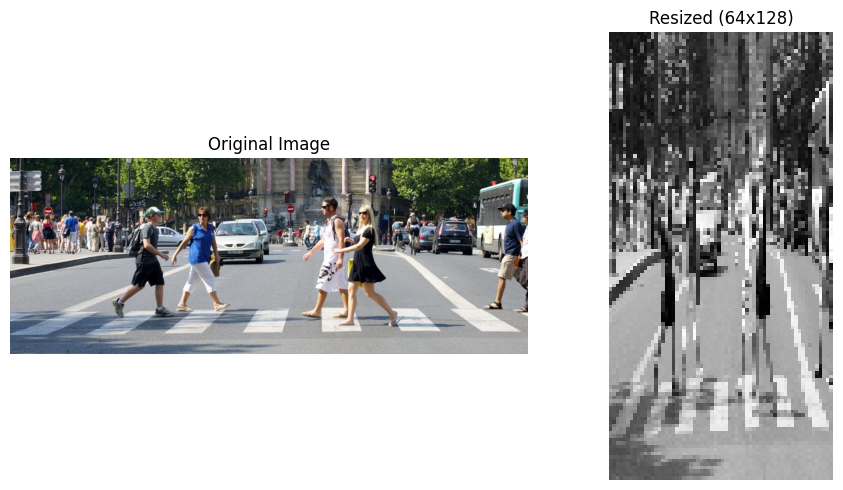

Prediction: Pedestrian


np.float64(1.0)

In [31]:
# Test on a pedestrian image
test_ped_path = "images/pedestrian.jpg"
print(f"\nTest 1: {test_ped_path}")
predict_image(test_ped_path, svm_classifier)


Test 2: images/non-pedestrian.png


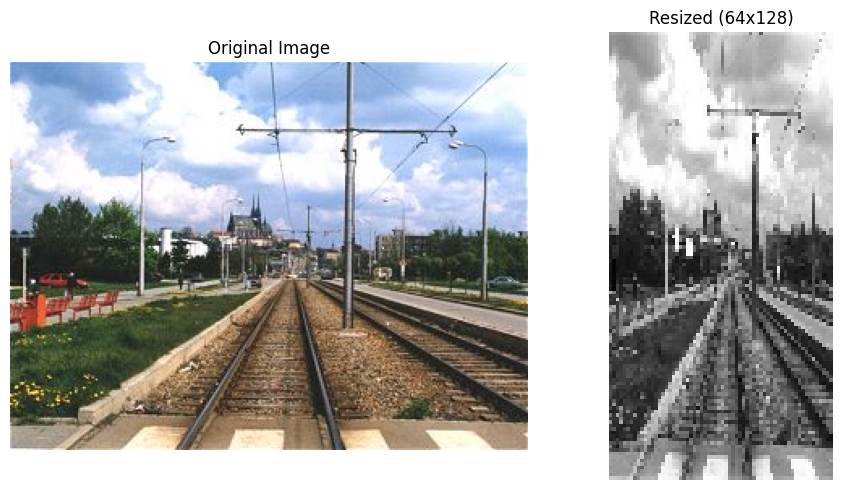

Prediction: Non-Pedestrian


np.float64(0.0)

In [32]:
# Test on a non-pedestrian image
test_neg_path = "images/non-pedestrian.png"
print(f"\nTest 2: {test_neg_path}")
predict_image(test_neg_path, svm_classifier)

### 6.3 Using OpenCV's Pre-trained HOG Detector

In [33]:
# Initialize HOG descriptor with default people detector
hog_detector = cv2.HOGDescriptor()
hog_detector.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

print("Pre-trained HOG+SVM pedestrian detector loaded")

Pre-trained HOG+SVM pedestrian detector loaded


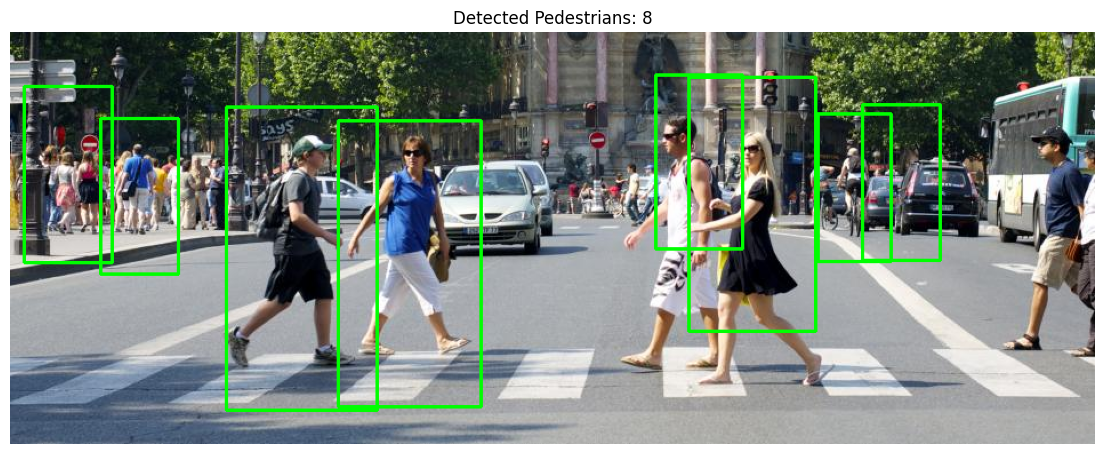

Number of detections: 8


In [34]:
# Detect pedestrians in image
test_img = cv2.imread('images/pedestrian.jpg')

if test_img is not None:

    boxes, weights = hog_detector.detectMultiScale(
        test_img,
        winStride=(4, 4),  
        padding=(8, 8),
        scale=1.02,         
        hitThreshold=0.1    
    )

    # Draw bounding boxes
    result_img = test_img.copy()
    for (x, y, w, h) in boxes:
        cv2.rectangle(result_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    plt.figure(figsize=(14, 8))
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Detected Pedestrians: {len(boxes)}')
    plt.axis('off')
    plt.show()
    
    print(f"Number of detections: {len(boxes)}")
else:
    print("Test image not found.")

## 7. Comparing Different HOG Parameters

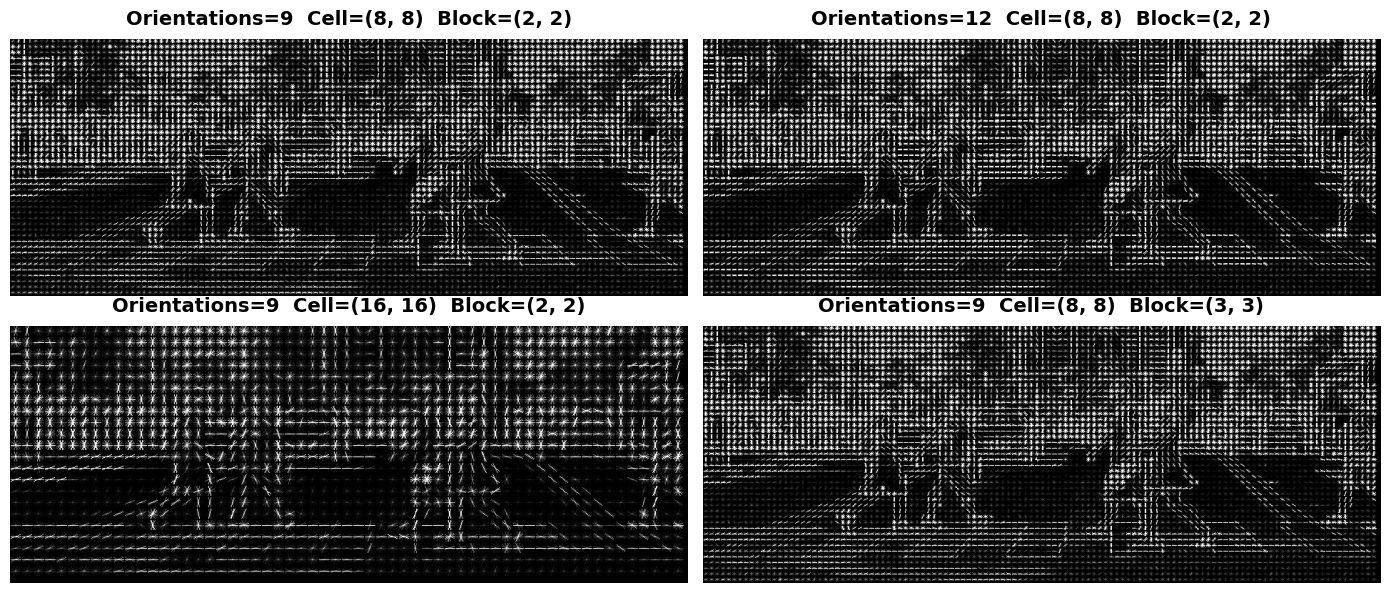

In [35]:
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

configs = [
    {'orientations': 9,  'pixels_per_cell': (8, 8),  'cells_per_block': (2, 2)},
    {'orientations': 12, 'pixels_per_cell': (8, 8),  'cells_per_block': (2, 2)},
    {'orientations': 9,  'pixels_per_cell': (16, 16), 'cells_per_block': (2, 2)},
    {'orientations': 9,  'pixels_per_cell': (8, 8),  'cells_per_block': (3, 3)},
]

plt.figure(figsize=(14, 6))

for i, config in enumerate(configs, 1):
    _, hog_img = hog(
        gray,
        orientations=config['orientations'],
        pixels_per_cell=config['pixels_per_cell'],
        cells_per_block=config['cells_per_block'],
        visualize=True,
        feature_vector=True
    )

    hog_img_rescaled = exposure.rescale_intensity(hog_img, in_range=(0, 10))

    plt.subplot(2, 2, i)
    plt.imshow(hog_img_rescaled, cmap='gray')
    plt.title(
        f"Orientations={config['orientations']}  "
        f"Cell={config['pixels_per_cell']}  "
        f"Block={config['cells_per_block']}",
        fontsize=14, fontweight='bold', pad=10
    )
    plt.axis('off')

plt.tight_layout()
plt.show()


## 8. Conclusion

**Advantages:**
- Invariant to local geometric and photometric transformations
- Efficient computation
- Works well with linear classifiers
- Interpretable features

**Limitations:**
- Fixed feature representation
- Manual parameter tuning required
- Less effective for complex patterns
- Outperformed by deep learning on large datasets

**Historical Impact:**
- Dominated computer vision (2005-2012)
- Foundation for understanding feature learning
- Inspired subsequent descriptors (SIFT, SURF)
- Transition point to learned features (CNNs)